Importing of libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import sqlite3
%matplotlib inline
import math
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler


Data Import

In [2]:
db_path = r"E:\Machine Learning Research\DataModelling\IDA_Data.db"  # <-- change this to your actual .db file path
table_name = "IDA_Data"                    # <-- your table name

conn = sqlite3.connect(db_path)
df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

# === Display===
# print(df.shape)
# print(list(df.columns))
# === Optionally, show first few rows ===
# print(InputHeads)
# print(OutputHeads)
# print("\nFirst 5 rows:")
# print(df.columns)
# df.columns

AllColumns = ['id', 'Earthquake', 'ScaleFactor', 'Building', 'BaseCondition', 'ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx', 'ly-lx-', 'lx-ly-', 'lx-ly--ly-lx-', 'Plan-area', 'Seismic-weight', 
              'StiffnessX_Story5', 'StiffnessX_Story4', 'StiffnessX_Story3', 'StiffnessX_Story2', 'StiffnessX_Story1', 'StiffnessX_Total', 'Layer1_FrictionA', 'Layer1_G_kPa', 
              'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion', 'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion',
              'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 'PGA', 'Magnitude', 'Mechanism', 'Rjb', 'Rrup', 'Vs30', 'cav_gs', 
              'scav_gs', 'bcav_gs', 'arias_mps', 'husid_s', 'spi_mps', 'hous_m', 'maxacceleration_mps2', 'maxvelocity_mps', 'maxdisplacement_m', 'maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps', 
              'Fundamental_Period', 'Drift-X_Level-1', 'Drift-X_Level-2', 'Drift-X_Level-3', 'Drift-X_Level-4', 'Drift-X_Level-5', 'Drift-X_Level-6', 'Drift-Y_Level-1', 'Drift-Y_Level-2',
              'Drift-Y_Level-3', 'Drift-Y_Level-4', 'Drift-Y_Level-5', 'Drift-Y_Level-6', 'Displacement-X_Level-1', 'Displacement-X_Level-2', 'Displacement-X_Level-3', 'Displacement-X_Level-4',
              'Displacement-X_Level-5', 'Displacement-X_Level-6', 'Displacement-Y_Level-1', 'Displacement-Y_Level-2', 'Displacement-Y_Level-3', 'Displacement-Y_Level-4', 'Displacement-Y_Level-5',
              'Displacement-Y_Level-6', 'Reaction-Force-X_Level-1', 'Reaction-Force-X_Level-2', 'Reaction-Force-X_Level-3', 'Reaction-Force-X_Level-4', 'Reaction-Force-X_Level-5', 'Reaction-Force-X_Level-6', 
              'Reaction-Force-Y_Level-1', 'Reaction-Force-Y_Level-2', 'Reaction-Force-Y_Level-3', 'Reaction-Force-Y_Level-4', 'Reaction-Force-Y_Level-5', 'Reaction-Force-Y_Level-6', 'Reaction-Moment-X_Level-1',
              'Reaction-Moment-X_Level-2', 'Reaction-Moment-X_Level-3', 'Reaction-Moment-X_Level-4', 'Reaction-Moment-X_Level-5', 'Reaction-Moment-X_Level-6', 'Reaction-Moment-Y_Level-1',
              'Reaction-Moment-Y_Level-2', 'Reaction-Moment-Y_Level-3', 'Reaction-Moment-Y_Level-4', 'Reaction-Moment-Y_Level-5', 'Reaction-Moment-Y_Level-6', 'Rotation-X_Level-1', 'Rotation-X_Level-2',
              'Rotation-X_Level-3', 'Rotation-X_Level-4', 'Rotation-X_Level-5', 'Rotation-X_Level-6', 'Rotation-Y_Level-1', 'Rotation-Y_Level-2', 'Rotation-Y_Level-3', 'Rotation-Y_Level-4', 'Rotation-Y_Level-5',
              'Rotation-Y_Level-6', 'Rotation-Z_Level-1', 'Rotation-Z_Level-2', 'Rotation-Z_Level-3', 'Rotation-Z_Level-4', 'Rotation-Z_Level-5', 'Rotation-Z_Level-6', 'Torsional-Irregularity-Ratio_Level-1',
              'Torsional-Irregularity-Ratio_Level-2', 'Torsional-Irregularity-Ratio_Level-3', 'Torsional-Irregularity-Ratio_Level-4', 'Torsional-Irregularity-Ratio_Level-5', 'Torsional-Irregularity-Ratio_Level-6',
              'Max-Uplift_Level-1', 'Max-Uplift-Point_Level-1', 'Max-Settlement_Level-1', 'Max-Settlement-Point_Level-1', 'Max-Pseudo-Time_Level-1']

Data Processing

In [3]:
#Data fixation for the model
DoNormalize = True
Z_ScoreScaler = True                       #If false then MinMax Scaler is used in the modelling
ModelSet = 2                        #1 denotes fixed base condtion (SF all upto 4), 2 denotes the SSI only case (SF upto 1 and inputheads include Layers) 3 denotes total datasets, (SF upto 1 , excluding the layers ie Fixed type similar)
includeCategoricalData = False               #True sets the categorical datta intact and False triggers the one hot encoding to the categorical data

# Creating of the PeakGroundAcceleration column on the database by product of ScaleFactor and MaximumAcceleration of the data
df['maxacceleration_mps2'] = pd.to_numeric(df['maxacceleration_mps2'], errors='coerce')
df['ScaleFactor'] = pd.to_numeric(df['ScaleFactor'], errors='coerce')
df['PeakGroundAcceleration'] = df['maxacceleration_mps2'] * df['ScaleFactor']

#Creating of the Prediction column as Max drift of the all levels merger in single column as below
drift_cols = [    'Drift-X_Level-1', 'Drift-X_Level-2', 'Drift-X_Level-3',    'Drift-X_Level-4', 'Drift-X_Level-5', 'Drift-X_Level-6']
df[drift_cols] = df[drift_cols].apply(pd.to_numeric, errors='coerce')
df['Max_Drift_X'] = df[drift_cols].max(axis=1)

# Check for any NaNs that might have appeared due to conversion issues
# print(df[['maxacceleration_mps2', 'ScaleFactor', 'PeakGroundAcceleration']].sample(50))
# print("Number of NaNs in new column:", df['PeakGroundAcceleration'].isna().sum())

InputHeadsAvailableAll = ['Earthquake', 'ScaleFactor', 'Building', 'BaseCondition', 'ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx', 'ly-lx-', 'lx-ly-', 'lx-ly--ly-lx-', 'Plan-area', 'Seismic-weight', 
              'StiffnessX_Story5', 'StiffnessX_Story4', 'StiffnessX_Story3', 'StiffnessX_Story2', 'StiffnessX_Story1', 'StiffnessX_Total', 
              'Layer1_FrictionA', 'Layer1_G_kPa', 'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion',
              'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion', 
              'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 
              'PGA', 'Magnitude', 'Mechanism', 'Rjb', 'Rrup', 'Vs30', 'cav_gs', 'scav_gs', 'bcav_gs', 'arias_mps', 'husid_s', 'spi_mps', 'hous_m', 'maxacceleration_mps2',
              'maxvelocity_mps', 'maxdisplacement_m', 'maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps', 
              'Fundamental_Period']
InputHeadsSelected = ['ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx', 'ly-lx-', 'lx-ly-', 'lx-ly--ly-lx-', 'Building', 'BaseCondition',
               
              'Layer1_FrictionA', 'Layer1_G_kPa', 'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion',
              'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion', 
              'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 
                      
              "PeakGroundAcceleration", 'Magnitude', 'arias_mps','maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps',  'cav_gs', 
                         'Fundamental_Period']

#Best performer for the fixedbase and displacement output
               # "PeakGroundAcceleration", 'Magnitude', 'arias_mps','maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps',  'cav_gs', 
               #           'Fundamental_Period']
#Best performer for the maximum drift along X with r2 as 89.36 (Donot include  'Plan-area', 'Seismic-weight', 'StiffnessX_Total', as they donot produce any effect and only add burden to model)
# InputHeadsSelected = ['ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx', 'ly-lx-', 'lx-ly-', 'lx-ly--ly-lx-',
               
#               'Layer1_FrictionA', 'Layer1_G_kPa', 'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion',
#               'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion', 
#               'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 
                      
#               "PeakGroundAcceleration", 'Magnitude', 'arias_mps','maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps',  'cav_gs', 
#                          'Fundamental_Period']
#Best performer for the fixed and output as Reaction-Force-X_Level-1:  r2 as 0.95 max with 15 features
# InputHeadsSelected = ['Earthquake', 'Building', 'Fundamental_Period',  'ly-Ly', 'lx-Lx', 'ly-Ly-lx-Lx',
#               'Layer1_FrictionA', 'Layer1_G_kPa', 'Layer1_E_kPa', 'Layer1_B_kPa', 'Layer1_SpGr', 'Layer1_Cohesion',
#               'Layer2_FrictionA', 'Layer2_G_kPa', 'Layer2_E_kPa', 'Layer2_B_kPa', 'Layer2_SpGr', 'Layer2_Cohesion', 
#               'Layer3_FrictionA', 'Layer3_G_kPa', 'Layer3_E_kPa', 'Layer3_B_kPa', 'Layer3_SpGr', 'Layer3_Cohesion', 
#                "PeakGroundAcceleration", 'arias_mps','maxpsd_cmps', 'maxsa_mps2', 'maxpsv_mps',
#                         ]
#For soil analysis take Rup, Vs30... Use maxacceleration_mps2 that represents the pga value of site and for the building specific analysis ie performance
# Levels measurement take PSA, PSV and PSD values over the peac acc peak vel and peak disp and so on 
#Final selected features (9): ['ScaleFactor', 'Vs30', 'cav_gs', 'arias_mps', 'husid_s', 'hous_m', 'maxvelocity_mps', 'maxdisplacement_m', 'maxpsd_cmps']



#_______________________________________________________________________________________________________________________________________________________________Processing starts from here
if ModelSet == 1 or ModelSet == 3:
    InputHeads = [x for x in InputHeadsSelected if not x.startswith("Layer")] 
else:
    InputHeads = InputHeadsSelected
# OutputHeads = ['Displacement-X_Level-5']
# OutputHeads = ["Reaction-Force-X_Level-1"]
OutputHeads = ['Max_Drift_X']

# df[InputHeads].info



In [4]:
####__________________________________________________________________________________________________________________________________Data selection 

# Extract all the data from the fixed base conditions only
if ModelSet == 1:
    df_fixed = df[df['BaseCondition'] == 'Fixed']
elif ModelSet == 2:
    df_fixed = df[df['BaseCondition'] != 'Fixed']
else:
    df_fixed = df[df['BaseCondition'].isin(['Fixed', 'Soft', 'Medium', 'Hard'])]
    

#Convert all the data in database to numerical format
if includeCategoricalData:
    df_numeric = df_fixed.copy()
    for col in df_numeric.columns:
        df_numeric[col] = pd.to_numeric(df_numeric[col], errors='ignore')
else:
    df_numeric = df_fixed.apply(pd.to_numeric, errors='coerce')
    df_numeric.shape

##Extract the data if the scale factor is less than or equal to 1 only
if ModelSet != 1:
    df_numeric = df_numeric[df_numeric['ScaleFactor'] <= 1]

####__________________________________________________________________________________________________________________________________Encoding of data
# # Normalize for the data of the features as seismic weights, and so on
features_to_normalize = [x for x in InputHeads
                         if pd.api.types.is_numeric_dtype(df_numeric[x])]


#One hot encoding of the categorical data if user set it to include in the model
if includeCategoricalData:
    print(len(features_to_normalize))
    print(len(InputHeads))
    print([x for x in InputHeads if x not in features_to_normalize])
    Catcolumns =  [x for x in InputHeads if x not in features_to_normalize]
    if Catcolumns:
        data_toEncode = df_numeric[Catcolumns]
    
        CatDataEncoded = pd.get_dummies(data_toEncode, columns = Catcolumns,  dtype=float)
        df_numeric = df_numeric.drop(columns=Catcolumns)
    
        if df_numeric.shape[0] == CatDataEncoded.shape[0]:
            df_numeric = pd.concat([df_numeric, CatDataEncoded], axis=1)
        else: 
            raise

#Removing all the white spaces on the column titles
df_numeric.columns = df_numeric.columns.str.replace(" ", "_")

## Converts all the data to the numeric even to that of hot encoded as they are in float
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')


####__________________________________________________________________________________________________________________________________Missing Data Handling
df_numeric =df_numeric.dropna(axis=1, how='all')             #Dropping for all the columns (axis = 1) if it has all values of NaN

#### Show only columns that actually contain NaN
# nan_counts = df_numeric.isna().sum()
# nan_counts = nan_counts[nan_counts > 0]
# print("Columns containing NaN values (column: count):")
# print(nan_counts)

# nan_rows = df_numeric[df_numeric.isna().any(axis=1)]
# print("Rows containing NaN values:")
# print(nan_rows)

df_numeric = df_numeric.apply(lambda col: col.fillna(col.median()) if col.dtype != 'object' else col)   #For any value other than object if the data is shown as missing then it fills up with the median of that column

# nan_counts = df_numeric.isna().sum()
# nan_counts = nan_counts[nan_counts > 0]
# print("Columns containing NaN values (column: count):")
# print(nan_counts)

df_numeric = df_numeric.dropna()                             #Now also if any of the Nan data persists then the system drops that specific rows


####__________________________________________________________________________________________________________________________________Normalization of data
if DoNormalize:
    scaler = MinMaxScaler(feature_range=(0, 1))
    if Z_ScoreScaler:
        scaler = StandardScaler()
    cols_to_scale = [c for c in features_to_normalize if c in df_numeric.columns] # Only normalize columns that actually exist in df
    df_numeric[cols_to_scale] = scaler.fit_transform(df_numeric[cols_to_scale])

####__________________________________________________________________________________________________________________________________Assignment of the training data

# # Extract for the data to be in x and y variables
X = df_numeric[[col for col in InputHeads if col in df_numeric.columns]]
y = df_numeric[[col for col in OutputHeads if col in df_numeric.columns]]

df_numeric = pd.concat([X, y], axis=1)  # combine X and y

# X.shape
# print((X.columns))
# cols = CatDataEncoded.columns
# for co in cols:
#     print(co)
# print(CatDataEncoded.columns)
# df_numeric.sample(10)
X.shape


(2523, 32)

In [5]:
import pandas as pd
import numpy as np

def generate_complete_data_statistics(X, y):
    """Generate comprehensive statistical summary for entire dataset"""
    
    # Convert to proper formats
    X_clean = X.apply(pd.to_numeric, errors='coerce')
    y_clean = y.values.ravel() if hasattr(y, 'values') else y
    
    print("COMPLETE DATASET STATISTICAL SUMMARY")
    print("="*80)
    print(f"{'Dataset':<20} {'Samples':<10} {'Features':<10}")
    print(f"{'':<20} {X_clean.shape[0]:<10} {X_clean.shape[1]:<10}")
    print("="*80)
    
    # Features summary
    print(f"\n{'FEATURES SUMMARY':<50}")
    print("-"*50)
    print(f"{'Parameter':<25} {'Count':<8} {'Mean':<12} {'Std':<12} {'Min':<10} {'Max':<10}")
    print("-"*50)
    
    for column in X_clean.columns:
        count = len(X_clean[column])
        mean = X_clean[column].mean()
        std = X_clean[column].std()
        min_val = X_clean[column].min()
        max_val = X_clean[column].max()
        
        print(f"{column:<25} {count:<8} {mean:<12.4f} {std:<12.4f} {min_val:<10.2f} {max_val:<10.2f}")

    # Target variable summary
    print(f"\n{'TARGET VARIABLE SUMMARY':<50}")
    print("-"*50)
    print(f"{'Parameter':<25} {'Count':<8} {'Mean':<12} {'Std':<12} {'Min':<10} {'Max':<10}")
    print("-"*50)
    
    count = len(y_clean)
    mean = y_clean.mean()
    std = y_clean.std()
    min_val = y_clean.min()
    max_val = y_clean.max()
    
    print(f"{'Target':<25} {count:<8} {mean:<12.4f} {std:<12.4f} {min_val:<10.2f} {max_val:<10.2f}")

    # Additional statistics
    print(f"\n{'ADDITIONAL STATISTICS':<50}")
    print("-"*50)
    print(f"{'Metric':<25} {'Value':<25}")
    print("-"*50)
    print(f"{'Total Samples':<25} {X_clean.shape[0]:<25}")
    print(f"{'Total Features':<25} {X_clean.shape[1]:<25}")
    print(f"{'Missing Values in X':<25} {X_clean.isnull().sum().sum():<25}")
    print(f"{'Missing Values in y':<25} {np.isnan(y_clean).sum():<25}")
    print(f"{'Target Skewness':<25} {pd.Series(y_clean).skew():<25.4f}")
    print(f"{'Target Kurtosis':<25} {pd.Series(y_clean).kurtosis():<25.4f}")

# Quick version for compact output
def quick_data_stats(X, y):
    """Quick statistical summary"""
    X_clean = X.apply(pd.to_numeric, errors='coerce')
    y_clean = y.values.ravel() if hasattr(y, 'values') else y
    
    print("DATASET STATISTICS")
    print("="*90)
    print(f"{'Parameter':<20} {'Count':<8} {'Mean':<12} {'Std':<12} {'Min':<10} {'Max':<10} {'Type':<10}")
    print("-"*90)
    
    # Features
    for column in X_clean.columns:
        data = X_clean[column]
        print(f"{column:<20} {len(data):<8} {data.mean():<12.4f} {data.std():<12.4f} "
              f"{data.min():<10.2f} {data.max():<10.2f} {'Feature':<10}")
    
    # Target
    print(f"{'Target':<20} {len(y_clean):<8} {y_clean.mean():<12.4f} {y_clean.std():<12.4f} "
          f"{y_clean.min():<10.2f} {y_clean.max():<10.2f} {'Target':<10}")

# Generate LaTeX table for research paper
def generate_latex_table(X, y):
    """Generate LaTeX table for research paper"""
    X_clean = X.apply(pd.to_numeric, errors='coerce')
    y_clean = y.values.ravel() if hasattr(y, 'values') else y
    
    print("\nLATEX TABLE FOR RESEARCH PAPER:")
    print("\\begin{table}[htbp]")
    print("\\centering")
    print("\\caption{Descriptive Statistics of the Complete Dataset}")
    print("\\label{tab:data_statistics}")
    print("\\begin{tabular}{lrrrrr}")
    print("\\hline")
    print("Parameter & Count & Mean & Std & Min & Max \\\\")
    print("\\hline")
    
    # Features
    for column in X_clean.columns:
        data = X_clean[column]
        print(f"{column} & {len(data)} & {data.mean():.4f} & {data.std():.4f} & {data.min():.2f} & {data.max():.2f} \\\\")
    
    # Target
    print(f"Target & {len(y_clean)} & {y_clean.mean():.4f} & {y_clean.std():.4f} & {y_clean.min():.2f} & {y_clean.max():.2f} \\\\")
    print("\\hline")
    print("\\end{tabular}")
    print("\\end{table}")



In [6]:
# # USAGE:
# print("ANALYZING COMPLETE DATASET")
# print("="*50)

# # Generate comprehensive statistics
# generate_complete_data_statistics(X, y)

# print("\n" + "="*50)
# print("QUICK STATISTICAL SUMMARY")
# print("="*50)

# # Generate quick statistics
# quick_data_stats(X, y)

# # Generate LaTeX table
# generate_latex_table(X, y)

 Features Selection

#Optuna based Hyperparameters Optimization

In [7]:
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-ready plots
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

class OptunaOptimizer:
    def __init__(self, X, y, n_trials=100, cv_folds=5, random_state=42, 
                 objective_metric='r2', use_advanced_params=True):
        self.X = X
        self.y = y.values.ravel() if hasattr(y, 'values') else y
        self.n_trials = n_trials
        self.cv_folds = cv_folds
        self.random_state = random_state
        self.objective_metric = objective_metric  # 'r2', 'neg_mse', 'neg_mae'
        self.use_advanced_params = use_advanced_params
        self.study = None
        self.best_params = None
        self.best_model = None
        self.oof_predictions = None
        self.oof_score = None
        
    def objective(self, trial):
        # Base parameters
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
            'random_state': self.random_state
        }
        # params = {
        #     'n_estimators': trial.suggest_int('n_estimators', 700, 1000),
        #     'max_depth': trial.suggest_int('max_depth', 9, 11),
        #     'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3, log=True),
        #     'subsample': trial.suggest_float('subsample', 0.6, 0.8),
        #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        #     'min_child_weight': trial.suggest_int('min_child_weight', 9, 10),
        #     'reg_lambda': trial.suggest_float('reg_lambda', 0.7, 0.9),
        #     'random_state': 19
        # }


        
        # Advanced parameters (conditional)
        if self.use_advanced_params:
            # params['reg_alpha'] = trial.suggest_float('reg_alpha', 0, 10)
            # params['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', 0.6, 1.0)
            # Tree method can be auto, exact, approx, hist
            params['tree_method'] = trial.suggest_categorical('tree_method', ['approx', 'hist'])        #['auto', 'exact', 'approx', 'hist']
        
        kf = KFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)
        cv_scores = []
        
        for train_idx, val_idx in kf.split(self.X):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]
            
            model = xgb.XGBRegressor(**params)
            model.fit(X_train, y_train, verbose=False)
            y_pred = model.predict(X_val)
            
            # Use selected metric
            if self.objective_metric == 'r2':
                score = r2_score(y_val, y_pred)
            elif self.objective_metric == 'neg_mse':
                score = -mean_squared_error(y_val, y_pred)  # Negative because we maximize
            elif self.objective_metric == 'neg_mae':
                score = -mean_absolute_error(y_val, y_pred)  # Negative because we maximize
            elif self.objective_metric == 'neg_rmse':
                score = -np.sqrt(mean_squared_error(y_val, y_pred))  # Negative because we maximize
            else:
                score = r2_score(y_val, y_pred)  # Default to R²
                
            cv_scores.append(score)
        
        return np.mean(cv_scores)
    
    def optimize(self):
        print(f"Starting Optuna optimization with {self.n_trials} trials...")
        print(f"Objective metric: {self.objective_metric}")
        print(f"Advanced parameters: {self.use_advanced_params}")
        
        self.study = optuna.create_study(direction='maximize', 
                                       sampler=optuna.samplers.TPESampler(seed=self.random_state))
        self.study.optimize(self.objective, n_trials=self.n_trials, show_progress_bar=True)
        
        self.best_params = self.study.best_params
        print(f"Best CV Score ({self.objective_metric}): {self.study.best_value:.6f}")
        return self.best_params
    
    def get_oof_predictions(self):
        """Generate Out-of-Fold predictions using best parameters"""
        kf = KFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)
        oof_preds = np.zeros(len(self.X))
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X)):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]
            
            model = xgb.XGBRegressor(**self.best_params)
            model.fit(X_train, y_train, verbose=False)
            oof_preds[val_idx] = model.predict(X_val)
        
        self.oof_predictions = oof_preds
        self.oof_score = r2_score(self.y, oof_preds)
        
        # Calculate additional metrics for OOF
        self.oof_mse = mean_squared_error(self.y, oof_preds)
        self.oof_rmse = np.sqrt(self.oof_mse)
        self.oof_mae = mean_absolute_error(self.y, oof_preds)
        
        print(f"Out-of-Fold R²: {self.oof_score:.6f}")
        print(f"Out-of-Fold RMSE: {self.oof_rmse:.6f}")
        print(f"Out-of-Fold MAE: {self.oof_mae:.6f}")
        
        return oof_preds

def create_compact_plots(optimizer, X, y):
    """Create publication-ready compact plots"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Optimization History
    history_df = optimizer.study.trials_dataframe()
    ax1.plot(history_df['number'], history_df['value'], 'b-', alpha=0.6, label='Trial Score')
    ax1.axhline(y=optimizer.study.best_value, color='r', linestyle='--', 
                label=f'Best {optimizer.objective_metric}: {optimizer.study.best_value:.4f}')
    ax1.set_xlabel('Trial Number')
    ax1.set_ylabel(f'CV {optimizer.objective_metric.upper()} Score')
    ax1.set_title('A) Optimization History', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Out-of-Fold Predictions vs Actual
    oof_preds = optimizer.oof_predictions
    ax2.scatter(y, oof_preds, alpha=0.6, s=30)
    max_val = max(np.max(y), np.max(oof_preds))
    min_val = min(np.min(y), np.min(oof_preds))
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Out-of-Fold Predictions')
    ax2.set_title(f'B) OOF Predictions vs Actual\nR² = {optimizer.oof_score:.4f}', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Parameter Importances
    try:
        importances = optuna.importance.get_param_importances(optimizer.study)
        params = list(importances.keys())
        importance_vals = list(importances.values())
        
        y_pos = np.arange(len(params))
        ax3.barh(y_pos, importance_vals, align='center')
        ax3.set_yticks(y_pos)
        ax3.set_yticklabels(params)
        ax3.set_xlabel('Importance')
        ax3.set_title('C) Hyperparameter Importances', fontweight='bold')
        ax3.grid(True, alpha=0.3)
    except:
        ax3.text(0.5, 0.5, 'Parameter importance\nnot available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('C) Hyperparameter Importances', fontweight='bold')
    
    # 4. Residuals Plot
    residuals = y - oof_preds
    ax4.scatter(oof_preds, residuals, alpha=0.6, s=30)
    ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax4.set_xlabel('Predicted Values')
    ax4.set_ylabel('Residuals')
    ax4.set_title(f'D) Residuals Analysis\nRMSE = {optimizer.oof_rmse:.4f}', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# MAIN EXECUTION BLOCK
# ====================
def main_optimization(X, y, objective_metric='r2', use_advanced_params=True, n_trials=50):
    """Complete optimization pipeline"""
    # Data preparation
    X_clean = X.apply(pd.to_numeric, errors='coerce')
    y_clean = y.values.ravel() if hasattr(y, 'values') else y
    
    print(f"Dataset: {X_clean.shape[0]} samples, {X_clean.shape[1]} features")
    
    # Run optimization
    optimizer = OptunaOptimizer(X_clean, y_clean, 
                               n_trials=n_trials, 
                               cv_folds=5, 
                               random_state=42,
                               objective_metric=objective_metric,
                               use_advanced_params=use_advanced_params)
    best_params = optimizer.optimize()
    
    # Generate OOF predictions
    oof_preds = optimizer.get_oof_predictions()
    
    # Create plots
    create_compact_plots(optimizer, y_clean, oof_preds)
    
    # Train final model with best parameters
    final_model = xgb.XGBRegressor(**best_params)
    final_model.fit(X_clean, y_clean)
    
    return optimizer, final_model, best_params

# USER CALLABLE FUNCTIONS
# =======================
def run_complete_analysis(objective_metric='r2', use_advanced_params=True, n_trials=50):
    """Run complete optimization and return results"""
    return main_optimization(X, y, objective_metric, use_advanced_params, n_trials= n_trials)

def get_final_model(optimizer, X, y):
    """Train final model with optimized parameters"""
    final_model = xgb.XGBRegressor(**optimizer.best_params)
    final_model.fit(X, y)
    return final_model

def get_research_metrics(optimizer):
    """Get metrics for research paper"""
    return {
        'best_cv_score': optimizer.study.best_value,
        'oof_r2': optimizer.oof_score,
        'oof_rmse': optimizer.oof_rmse,
        'oof_mae': optimizer.oof_mae,
        'best_params': optimizer.best_params,
        'objective_metric': optimizer.objective_metric
    }



# PRINT ALL METRICS FOR PAPER
def print_paper_metrics(optimizer):
    """Print formatted metrics for research paper"""
    metrics = get_research_metrics(optimizer)
    print("\n" + "="*50)
    print("RESEARCH PAPER METRICS")
    print("="*50)
    print(f"Out-of-Fold R²: {metrics['oof_r2']:.6f}")
    print(f"Out-of-Fold RMSE: {metrics['oof_rmse']:.6f}")
    print(f"Out-of-Fold MAE: {metrics['oof_mae']:.6f}")
    print(f"Optimization Metric: {metrics['objective_metric']}")
    print(f"Best CV Score: {metrics['best_cv_score']:.6f}")
    return metrics




[I 2025-11-24 17:47:20,237] A new study created in memory with name: no-name-47ab9faa-f5ce-47c9-b461-15a54e4f55d1


Dataset: 2523 samples, 32 features
Starting Optuna optimization with 50 trials...
Objective metric: r2
Advanced parameters: False


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-24 17:47:21,115] Trial 0 finished with value: 0.9397320204827727 and parameters: {'n_estimators': 437, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'reg_lambda': 0.6750277604651747}. Best is trial 0 with value: 0.9397320204827727.
[I 2025-11-24 17:47:23,083] Trial 1 finished with value: 0.9462513897359628 and parameters: {'n_estimators': 880, 'max_depth': 9, 'learning_rate': 0.11114989443094977, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'min_child_weight': 9, 'reg_lambda': 2.202157195714934}. Best is trial 1 with value: 0.9462513897359628.
[I 2025-11-24 17:47:23,732] Trial 2 finished with value: 0.9426965207254121 and parameters: {'n_estimators': 263, 'max_depth': 4, 'learning_rate': 0.028145092716060652, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'min_child_weight': 3, 'reg_lambda': 6.157343657751556}. Best is t

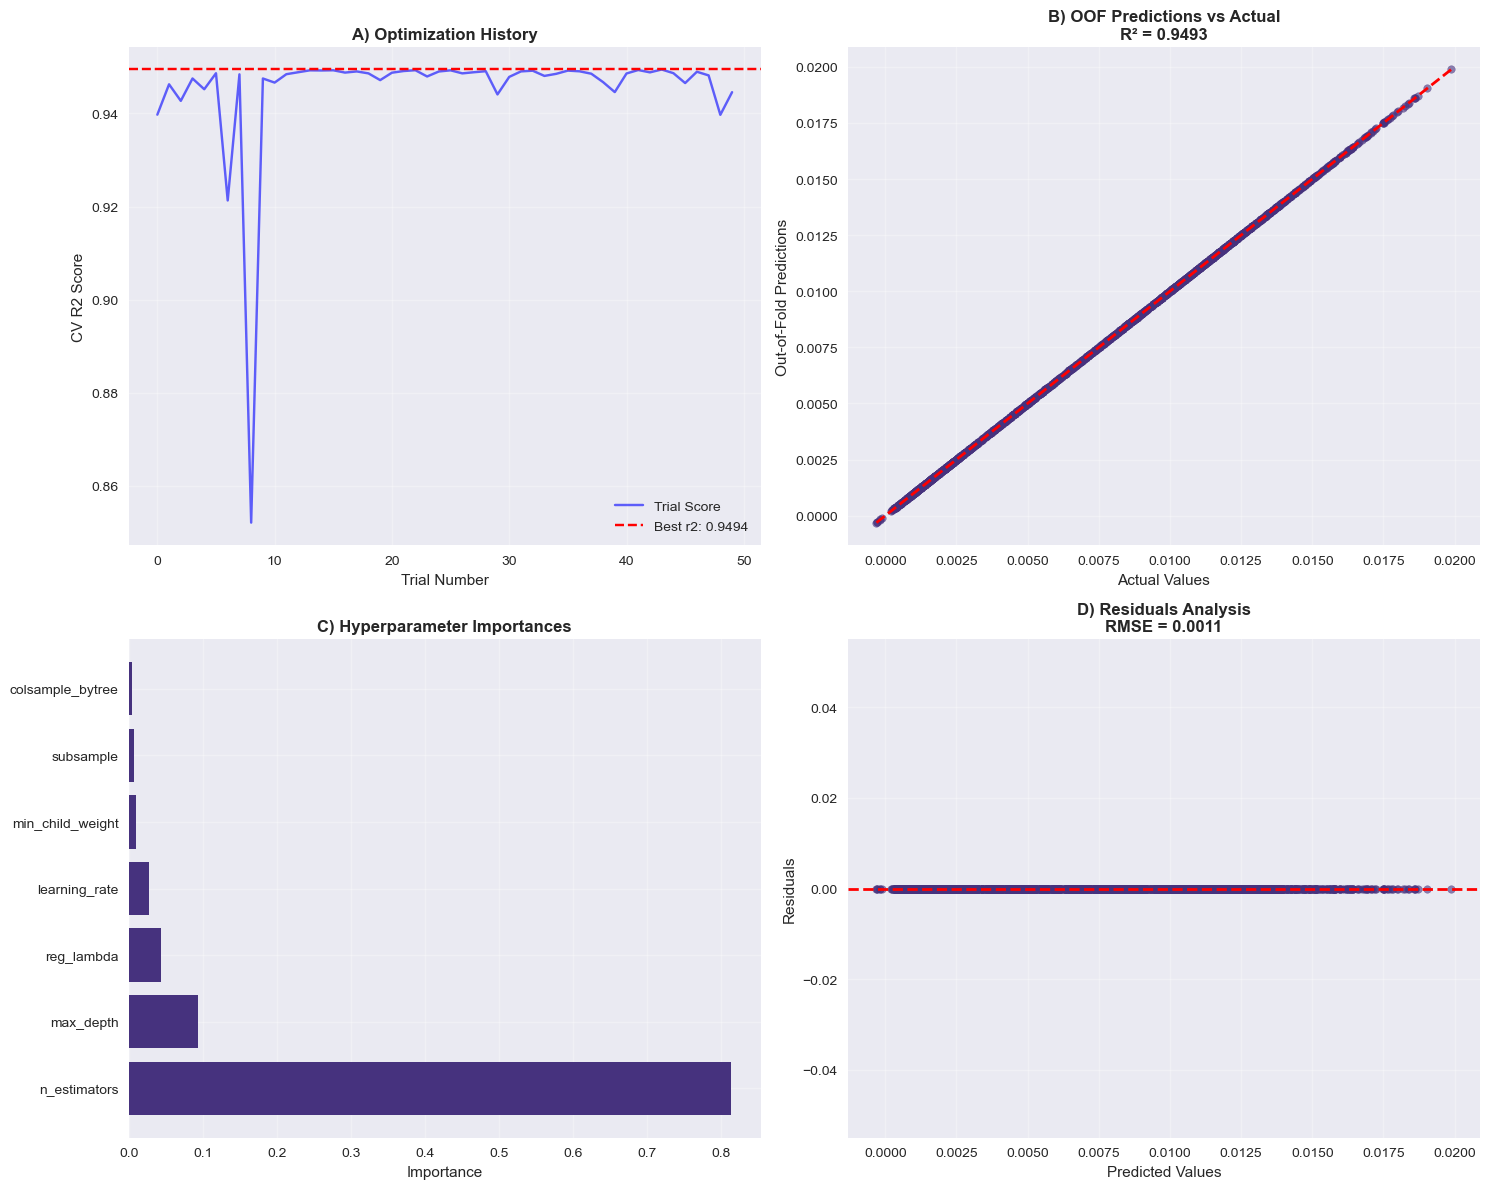


RESEARCH PAPER METRICS
Out-of-Fold R²: 0.949329
Out-of-Fold RMSE: 0.001097
Out-of-Fold MAE: 0.000703
Optimization Metric: r2
Best CV Score: 0.949431

Research Paper R²: 0.949329


In [8]:
# # EXECUTE OPTIMIZATION (Choose your configuration)
# # ================================================

# Option 1: Basic R² optimization (recommended for paper)
optimizer, final_model, best_params = run_complete_analysis(objective_metric='r2', use_advanced_params=False, n_trials=50)

# Option 2: MSE optimization (penalizes large errors more)
# optimizer, final_model, best_params = run_complete_analysis(objective_metric='neg_mse', use_advanced_params=True)

# Option 3: MAE optimization (more robust to outliers)
# optimizer, final_model, best_params = run_complete_analysis(objective_metric='neg_mae', use_advanced_params=True)

# Option 4: Basic parameters only (faster)
# optimizer, final_model, best_params = run_complete_analysis(objective_metric='r2', use_advanced_params=False)

# RESEARCH PAPER METRIC
# =====================
# The R² value to report in your paper after hyperparameter optimization:
optimizer.oof_score

# Get paper metrics
paper_metrics = print_paper_metrics(optimizer)

# THE R² VALUE FOR YOUR PAPER:
research_r2 = optimizer.oof_score
print(f"\nResearch Paper R²: {research_r2:.6f}")

In [9]:
# Read Run only the model with optimized hyperparameters

In [12]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

# Set style for publication-ready plots
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

class OptimizedModel:
    def __init__(self, parameters, X, y, cv_folds=5, random_state=42):
        self.X = X
        self.y = y.values.ravel() if hasattr(y, 'values') else y
        self.cv_folds = cv_folds
        self.random_state = random_state
        
        # Your optimized parameters
        self.best_params = parameters
        
        self.best_model = None
        self.oof_predictions = None
        self.oof_score = None
        self.model_info = {}
    
    def get_oof_predictions(self):
        """Generate Out-of-Fold predictions using optimized parameters"""
        kf = KFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)
        oof_preds = np.zeros(len(self.X))
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X)):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]
            
            model = xgb.XGBRegressor(**self.best_params)
            model.fit(X_train, y_train, verbose=False)
            fold_preds = model.predict(X_val)
            oof_preds[val_idx] = fold_preds
            
            fold_r2 = r2_score(y_val, fold_preds)
            fold_scores.append(fold_r2)
        
        self.oof_predictions = oof_preds
        self.oof_score = r2_score(self.y, oof_preds)
        
        # Calculate additional metrics
        self.oof_mse = mean_squared_error(self.y, oof_preds)
        self.oof_rmse = np.sqrt(self.oof_mse)
        self.oof_mae = mean_absolute_error(self.y, oof_preds)
        self.oof_mape = np.mean(np.abs((self.y - oof_preds) / self.y)) * 100
        
        # Store fold scores
        self.fold_scores = fold_scores
        self.fold_scores_mean = np.mean(fold_scores)
        self.fold_scores_std = np.std(fold_scores)
        
        print(f"Out-of-Fold R²: {self.oof_score:.6f}")
        print(f"Out-of-Fold RMSE: {self.oof_rmse:.6f}")
        print(f"Out-of-Fold MAE: {self.oof_mae:.6f}")
        print(f"Out-of-Fold MAPE: {self.oof_mape:.6f}%")
        
        return oof_preds
    
    def train_final_model(self):
        """Train final model on all data"""
        self.best_model = xgb.XGBRegressor(**self.best_params)
        self.best_model.fit(self.X, self.y)
        
        # Calculate training metrics
        y_train_pred = self.best_model.predict(self.X)
        self.train_r2 = r2_score(self.y, y_train_pred)
        self.train_rmse = np.sqrt(mean_squared_error(self.y, y_train_pred))
        self.train_mae = mean_absolute_error(self.y, y_train_pred)
        
        return self.best_model
    
    def collect_model_info(self, X_test=None, y_test=None):
        """Collect all model information for saving"""
        self.model_info = {
            'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'dataset_info': {
                'samples': self.X.shape[0],
                'features': self.X.shape[1],
                'feature_names': self.X.columns.tolist()
            },
            'hyperparameters': self.best_params,
            'cross_validation': {
                'folds': self.cv_folds,
                'fold_scores': self.fold_scores,
                'fold_mean_score': self.fold_scores_mean,
                'fold_std_score': self.fold_scores_std
            },
            'out_of_fold_metrics': {
                'r2_score': self.oof_score,
                'rmse': self.oof_rmse,
                'mse': self.oof_mse,
                'mae': self.oof_mae,
                'mape': self.oof_mape
            },
            'training_metrics': {
                'r2_score': self.train_r2,
                'rmse': self.train_rmse,
                'mae': self.train_mae
            },
            'feature_importance': dict(zip(self.X.columns, self.best_model.feature_importances_))
        }
        
        # Add test metrics if available
        if X_test is not None and y_test is not None:
            y_test_pred = self.best_model.predict(X_test)
            self.model_info['test_metrics'] = {
                'r2_score': r2_score(y_test, y_test_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
                'mae': mean_absolute_error(y_test, y_test_pred)
            }
        
        # Add plot data
        self.model_info['plot_data'] = {
            'actual_values': self.y.tolist(),
            'predicted_values': self.oof_predictions.tolist(),
            'residuals': (self.y - self.oof_predictions).tolist()
        }

# def save_model_information(X, y, model, filename_prefix="model_info"):
#     """Save all model information to text files"""
#     timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
#     # 1. Save detailed information as JSON
#     json_filename = f"{filename_prefix}_{timestamp}.json"
#     with open(json_filename, 'w') as f:
#         json.dump(model.model_info, f, indent=2, default=str)
    
#     # 2. Save human-readable summary
#     txt_filename = f"{filename_prefix}_{timestamp}.txt"
#     with open(txt_filename, 'w') as f:
#         f.write("="*80 + "\n")
#         f.write("XGBOOST MODEL COMPLETE INFORMATION\n")
#         f.write("="*80 + "\n\n")
        
#         f.write(f"Generated\t{model.model_info['timestamp']}\n\n")
        
#         # Dataset Info
#         f.write("DATASET INFORMATION\n")
#         f.write("-" * 40 + "\n")
#         f.write(f"Samples\t{model.model_info['dataset_info']['samples']}\n")
#         f.write(f"Features\t{model.model_info['dataset_info']['features']}\n")
#         f.write("Feature_Names\t" + "\t".join(model.model_info['dataset_info']['feature_names']) + "\n\n")
        
#         # Hyperparameters
#         f.write("HYPERPARAMETERS\n")
#         f.write("-" * 40 + "\n")
#         for param, value in model.model_info['hyperparameters'].items():
#             f.write(f"{param}\t{value}\n")
#         f.write("\n")
        
#         # Cross-Validation Results
#         f.write("CROSS-VALIDATION RESULTS\n")
#         f.write("-" * 40 + "\n")
#         for i, score in enumerate(model.model_info['cross_validation']['fold_scores'], 1):
#             f.write(f"Fold_{i}\t{score:.6f}\n")
#         f.write(f"Mean_CV_R2\t{model.model_info['cross_validation']['fold_mean_score']:.6f}\n")
#         f.write(f"Std_CV_R2\t{model.model_info['cross_validation']['fold_std_score']:.6f}\n\n")
        
#         # Out-of-Fold Metrics
#         f.write("OUT-OF-FOLD METRICS\n")
#         f.write("-" * 40 + "\n")
#         oof_metrics = model.model_info['out_of_fold_metrics']
#         f.write(f"R2_Score\t{oof_metrics['r2_score']:.6f}\n")
#         f.write(f"RMSE\t{oof_metrics['rmse']:.6f}\n")
#         f.write(f"MSE\t{oof_metrics['mse']:.6f}\n")
#         f.write(f"MAE\t{oof_metrics['mae']:.6f}\n")
#         f.write(f"MAPE\t{oof_metrics['mape']:.6f}\n\n")
        
#         # Training Metrics
#         f.write("TRAINING METRICS (Full Dataset)\n")
#         f.write("-" * 40 + "\n")
#         train_metrics = model.model_info['training_metrics']
#         f.write(f"R2_Score\t{train_metrics['r2_score']:.6f}\n")
#         f.write(f"RMSE\t{train_metrics['rmse']:.6f}\n")
#         f.write(f"MAE\t{train_metrics['mae']:.6f}\n\n")
        
#         # Test Metrics (if available)
#         if 'test_metrics' in model.model_info:
#             f.write("TEST METRICS\n")
#             f.write("-" * 40 + "\n")
#             test_metrics = model.model_info['test_metrics']
#             f.write(f"R2_Score\t{test_metrics['r2_score']:.6f}\n")
#             f.write(f"RMSE\t{test_metrics['rmse']:.6f}\n")
#             f.write(f"MAE\t{test_metrics['mae']:.6f}\n\n")
        
#         # Feature Importance
#         f.write("FEATURE IMPORTANCE (Top 15)\n")
#         f.write("-" * 40 + "\n")
#         importance_df = pd.DataFrame({
#             'Feature': list(model.model_info['feature_importance'].keys()),
#             'Importance': list(model.model_info['feature_importance'].values())
#         }).sort_values('Importance', ascending=False)
        
#         f.write("Feature\tImportance_Score\n")
#         for _, row in importance_df.head(15).iterrows():
#             f.write(f"{row['Feature']}\t{row['Importance']:.6f}\n")
        
#         # Research Paper Summary
#         f.write("\n" + "="*80 + "\n")
#         f.write("RESEARCH PAPER SUMMARY\n")
#         f.write("="*80 + "\n")
#         f.write(f"Out_of_Fold_R2\t{model.oof_score:.6f}\n")
#         f.write(f"Out_of_Fold_RMSE\t{model.oof_rmse:.6f}\n")
#         f.write(f"Out_of_Fold_MAE\t{model.oof_mae:.6f}\n")
#         if 'test_metrics' in model.model_info:
#             f.write(f"Test_R2\t{model.model_info['test_metrics']['r2_score']:.6f}\n")

#         # Add separator and model predictions
#         f.write('\n' + '='*80 + '\n')
#         f.write('MODEL PREDICTIONS AND RESIDUALS\n')
#         f.write('='*80 + '\n')
        
#         pred_headers = ['Actual', 'Predicted', 'Residuals', 'Absolute_Error', 'Percent_Error']
#         f.write('\t'.join(pred_headers) + '\n')
#         predictions = model.oof_predictions
        
#         y_clean1 = y.values.ravel() if hasattr(y, 'values') else y
#         for i in range(len(y_clean1)):
#             actual = y_clean[i]
#             predicted = predictions[i]
#             residual = actual - predicted
#             abs_error = abs(residual)
#             percent_error = (abs_error / actual * 100) if actual != 0 else 0
            
#             row = [f"{actual:.6f}", f"{predicted:.6f}", f"{residual:.6f}", f"{abs_error:.6f}", f"{percent_error:.6f}"]
#             f.write('\t'.join(row) + '\n')
            
    
#     # 3. Save plot data as CSV
#     csv_filename = f"{filename_prefix}_plot_data_{timestamp}.csv"
#     plot_data = pd.DataFrame({
#         'Actual': model.model_info['plot_data']['actual_values'],
#         'Predicted': model.model_info['plot_data']['predicted_values'],
#         'Residuals': model.model_info['plot_data']['residuals']
#     })
#     plot_data.to_csv(csv_filename, index=False)
    
#     # 4. Save feature importance as CSV
#     feature_importance_filename = f"{filename_prefix}_feature_importance_{timestamp}.csv"
#     importance_df.to_csv(feature_importance_filename, index=False)
    
#     print(f"\nModel information saved to:")
#     print(f"  - {json_filename} (Detailed JSON)")
#     print(f"  - {txt_filename} (Human-readable summary)")
#     print(f"  - {csv_filename} (Plot data)")
#     print(f"  - {feature_importance_filename} (Feature importance)")

def create_compact_plots(model, y):
    """Create publication-ready compact plots"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Out-of-Fold Predictions vs Actual
    oof_preds = model.oof_predictions
    ax1.scatter(y, oof_preds, alpha=0.6, s=30)
    max_val = max(np.max(y), np.max(oof_preds))
    min_val = min(np.min(y), np.min(oof_preds))
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Out-of-Fold Predictions')
    ax1.set_title(f'A) OOF Predictions vs Actual\nR² = {model.oof_score:.4f}', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. Residuals Plot
    residuals = y - oof_preds
    ax2.scatter(oof_preds, residuals, alpha=0.6, s=30)
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'B) Residuals Analysis\nRMSE = {model.oof_rmse:.4f}', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Feature Importance
    if model.best_model is not None:
        feature_importance = model.best_model.feature_importances_
        feature_names = model.X.columns
        
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        top_features = importance_df.head(15)
        ax3.barh(top_features['Feature'], top_features['Importance'])
        ax3.set_xlabel('Feature Importance Score')
        ax3.set_title('C) Top Feature Importance', fontweight='bold')
        ax3.grid(True, alpha=0.3)
    
    # 4. Prediction Distribution
    ax4.hist(y, bins=30, alpha=0.7, label='Actual', color='blue')
    ax4.hist(oof_preds, bins=30, alpha=0.7, label='Predicted', color='orange')
    ax4.set_xlabel('Values')
    ax4.set_ylabel('Frequency')
    ax4.set_title('D) Distribution: Actual vs Predicted', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'model_plots_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.png', dpi=300, bbox_inches='tight')
    plt.show()


# Usage in your main function:
def run_optimized_model_with_data_export(parameters, X, y, X_test=None, y_test=None):
    """Run complete analysis and export data in Excel-friendly format"""
    # Data preparation
    X_clean = X.apply(pd.to_numeric, errors='coerce')
    y_clean = y.values.ravel() if hasattr(y, 'values') else y
    
    print(f"Dataset: {X_clean.shape[0]} samples, {X_clean.shape[1]} features")
    
    # Create and run model
    model = OptimizedModel(parameters, X_clean, y_clean, cv_folds=5, random_state=42)
    oof_preds = model.get_oof_predictions()
    final_model = model.train_final_model()
    
    # Collect model information
    model.collect_model_info(X_test, y_test)
    

    
    # Create plots
    create_compact_plots(model, y_clean)
    
    
    # RESEARCH PAPER R² VALUE
    print(f"\n📊 RESEARCH PAPER R²: {model.oof_score:.6f}")
    
    return model, final_model

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import datetime

def extract_final_model_info(final_model, X, y, filename="final_model_complete_info.txt"):
    """
    Extract ALL information from final model object and save in tab-separated format
    
    Parameters:
    - final_model: Trained XGBoost model object
    - X: Feature dataset (pandas DataFrame)
    - y: Target variable
    - filename: Output filename
    """
    
    # Prepare data
    X_clean = X.apply(pd.to_numeric, errors='coerce')
    y_clean = y.values.ravel() if hasattr(y, 'values') else y
    
    # Generate predictions
    y_pred = final_model.predict(X_clean)
    
    # Calculate all metrics
    r2 = r2_score(y_clean, y_pred)
    mse = mean_squared_error(y_clean, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_clean, y_pred)
    mape = np.mean(np.abs((y_clean - y_pred) / y_clean)) * 100
    
    # Get feature importance
    feature_importance = final_model.feature_importances_
    feature_names = X_clean.columns
    
    # Sort features by importance
    importance_data = list(zip(feature_names, feature_importance))
    importance_data.sort(key=lambda x: x[1], reverse=True)
    
    with open(filename, 'w') as f:
        # ===== SECTION 1: BASIC MODEL INFORMATION =====
        f.write("=" * 80 + "\n")
        f.write("FINAL MODEL COMPLETE INFORMATION\n")
        f.write("=" * 80 + "\n\n")
        
        f.write("TIMESTAMP\t" + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "\n\n")
        
        # ===== SECTION 2: DATASET INFORMATION =====
        f.write("DATASET INFORMATION\n")
        f.write("-" * 40 + "\n")
        f.write(f"Samples\t{X_clean.shape[0]}\n")
        f.write(f"Features\t{X_clean.shape[1]}\n")
        f.write("Feature_Names\t" + "\t".join(X_clean.columns.tolist()) + "\n\n")
        
        # ===== SECTION 3: MODEL HYPERPARAMETERS =====
        f.write("MODEL HYPERPARAMETERS\n")
        f.write("-" * 40 + "\n")
        params = final_model.get_params()
        for param, value in params.items():
            f.write(f"{param}\t{value}\n")
        f.write("\n")
        
        # ===== SECTION 4: TRAINING METRICS =====
        f.write("TRAINING PERFORMANCE METRICS\n")
        f.write("-" * 40 + "\n")
        f.write(f"R2_Score\t{r2:.6f}\n")
        f.write(f"RMSE\t{rmse:.6f}\n")
        f.write(f"MSE\t{mse:.6f}\n")
        f.write(f"MAE\t{mae:.6f}\n")
        f.write(f"MAPE\t{mape:.6f}\n\n")
        
        # ===== SECTION 5: MODEL INTERNAL ATTRIBUTES =====
        f.write("MODEL INTERNAL ATTRIBUTES\n")
        f.write("-" * 40 + "\n")
        
        # Extract available attributes
        model_attrs = [attr for attr in dir(final_model) if not attr.startswith('_')]
        
        # Write basic attributes
        basic_attrs = [
            'n_estimators', 'max_depth', 'learning_rate', 
            'objective', 'booster', 'tree_method'
        ]
        
        for attr in basic_attrs:
            if hasattr(final_model, attr):
                value = getattr(final_model, attr)
                f.write(f"{attr}\t{value}\n")
        
        # Additional XGBoost specific attributes
        xgb_attrs = [
            'best_score', 'best_iteration', 'best_ntree_limit',
            'feature_names_in_', 'n_features_in_'
        ]
        
        for attr in xgb_attrs:
            if hasattr(final_model, attr):
                value = getattr(final_model, attr)
                f.write(f"{attr}\t{value}\n")
        
        f.write("\n")
        
        # ===== SECTION 6: FEATURE IMPORTANCE =====
        f.write("FEATURE IMPORTANCE (ALL FEATURES)\n")
        f.write("-" * 40 + "\n")
        f.write("Feature\tImportance_Score\tRank\n")
        
        for rank, (feature, importance) in enumerate(importance_data, 1):
            f.write(f"{feature}\t{importance:.6f}\t{rank}\n")
        f.write("\n")
        
        # ===== SECTION 7: PREDICTION STATISTICS =====
        f.write("PREDICTION STATISTICS\n")
        f.write("-" * 40 + "\n")
        
        pred_stats = [
            f"Min_Prediction\t{np.min(y_pred):.6f}",
            f"Max_Prediction\t{np.max(y_pred):.6f}",
            f"Mean_Prediction\t{np.mean(y_pred):.6f}",
            f"Std_Prediction\t{np.std(y_pred):.6f}",
            f"Min_Actual\t{np.min(y_clean):.6f}",
            f"Max_Actual\t{np.max(y_clean):.6f}",
            f"Mean_Actual\t{np.mean(y_clean):.6f}",
            f"Std_Actual\t{np.std(y_clean):.6f}"
        ]
        
        for stat in pred_stats:
            f.write(stat + "\n")
        f.write("\n")
        
        # ===== SECTION 8: RESIDUAL ANALYSIS =====
        f.write("RESIDUAL ANALYSIS\n")
        f.write("-" * 40 + "\n")
        
        residuals = y_clean - y_pred
        residual_stats = [
            f"Min_Residual\t{np.min(residuals):.6f}",
            f"Max_Residual\t{np.max(residuals):.6f}",
            f"Mean_Residual\t{np.mean(residuals):.6f}",
            f"Std_Residual\t{np.std(residuals):.6f}",
            f"Median_Absolute_Residual\t{np.median(np.abs(residuals)):.6f}",
            f"Residual_Skewness\t{pd.Series(residuals).skew():.6f}",
            f"Residual_Kurtosis\t{pd.Series(residuals).kurtosis():.6f}"
        ]
        
        for stat in residual_stats:
            f.write(stat + "\n")
        f.write("\n")
        
        # ===== SECTION 9: DETAILED PREDICTIONS TABLE =====
        f.write("DETAILED PREDICTIONS AND RESIDUALS\n")
        f.write("-" * 40 + "\n")
        f.write("Index\tActual\tPredicted\tResidual\tAbsolute_Error\tPercent_Error\tSquared_Error\n")
        
        for i in range(len(y_clean)):
            actual = y_clean[i]
            predicted = y_pred[i]
            residual = actual - predicted
            abs_error = abs(residual)
            percent_error = (abs_error / actual * 100) if actual != 0 else 0
            squared_error = residual ** 2
            
            row = [
                str(i),
                f"{actual:.6f}",
                f"{predicted:.6f}",
                f"{residual:.6f}",
                f"{abs_error:.6f}",
                f"{percent_error:.6f}",
                f"{squared_error:.6f}"
            ]
            f.write('\t'.join(row) + '\n')
        
        # ===== SECTION 10: MODEL PERFORMANCE SUMMARY =====
        f.write("\n" + "=" * 80 + "\n")
        f.write("MODEL PERFORMANCE SUMMARY\n")
        f.write("=" * 80 + "\n")
        
        summary_metrics = [
            f"Final_R2_Score\t{r2:.6f}",
            f"Final_RMSE\t{rmse:.6f}",
            f"Final_MAE\t{mae:.6f}",
            f"Final_MAPE\t{mape:.6f}%",
            f"Best_Feature\t{importance_data[0][0]}",
            f"Best_Feature_Importance\t{importance_data[0][1]:.6f}",
            f"Training_Samples\t{len(y_clean)}"
        ]
        
        for metric in summary_metrics:
            f.write(metric + "\n")
    
    print(f"✅ Complete final model information saved to: {filename}")
    print(f"📊 Final Model R² Score: {r2:.6f}")
    print(f"📈 Final Model RMSE: {rmse:.6f}")
    
    # Return extracted information for potential further use
    return {
        'metrics': {
            'r2': r2,
            'rmse': rmse,
            'mse': mse,
            'mae': mae,
            'mape': mape
        },
        'feature_importance': dict(importance_data),
        'predictions': y_pred,
        'residuals': residuals
    }
    
def compare_multiple_models(model_dict, X, y, filename="model_comparison.txt"):
    """
    Compare multiple final models and save results in tab-separated format
    
    Parameters:
    - model_dict: Dictionary with model names as keys and model objects as values
    - X: Feature dataset
    - y: Target variable
    - filename: Output filename
    """
    
    with open(filename, 'w') as f:
        f.write("MODEL COMPARISON REPORT\n")
        f.write("=" * 80 + "\n\n")
        f.write("Model_Name\tR2_Score\tRMSE\tMAE\tMAPE\tBest_Feature\tTop_Feature_Importance\n")
        
        comparison_results = {}
        
        for model_name, model in model_dict.items():
            # Calculate metrics
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            mae = mean_absolute_error(y, y_pred)
            mape = np.mean(np.abs((y - y_pred) / y)) * 100
            
            # Get best feature
            feature_importance = model.feature_importances_
            feature_names = X.columns
            best_feature_idx = np.argmax(feature_importance)
            best_feature = feature_names[best_feature_idx]
            best_importance = feature_importance[best_feature_idx]
            
            # Write to file
            f.write(f"{model_name}\t{r2:.6f}\t{rmse:.6f}\t{mae:.6f}\t{mape:.6f}\t{best_feature}\t{best_importance:.6f}\n")
            
            # Store for return
            comparison_results[model_name] = {
                'r2': r2,
                'rmse': rmse,
                'mae': mae,
                'mape': mape,
                'best_feature': best_feature
            }
    
    print(f"✅ Model comparison saved to: {filename}")
    return comparison_results

In [13]:
# Example usage:
# final_model_info = extract_final_model_info(final_model, X_clean, y_clean, "final_model_complete_analysis.txt")

Dataset: 2523 samples, 32 features
Out-of-Fold R²: 0.928964
Out-of-Fold RMSE: 0.001299
Out-of-Fold MAE: 0.000873
Out-of-Fold MAPE: 17.512292%


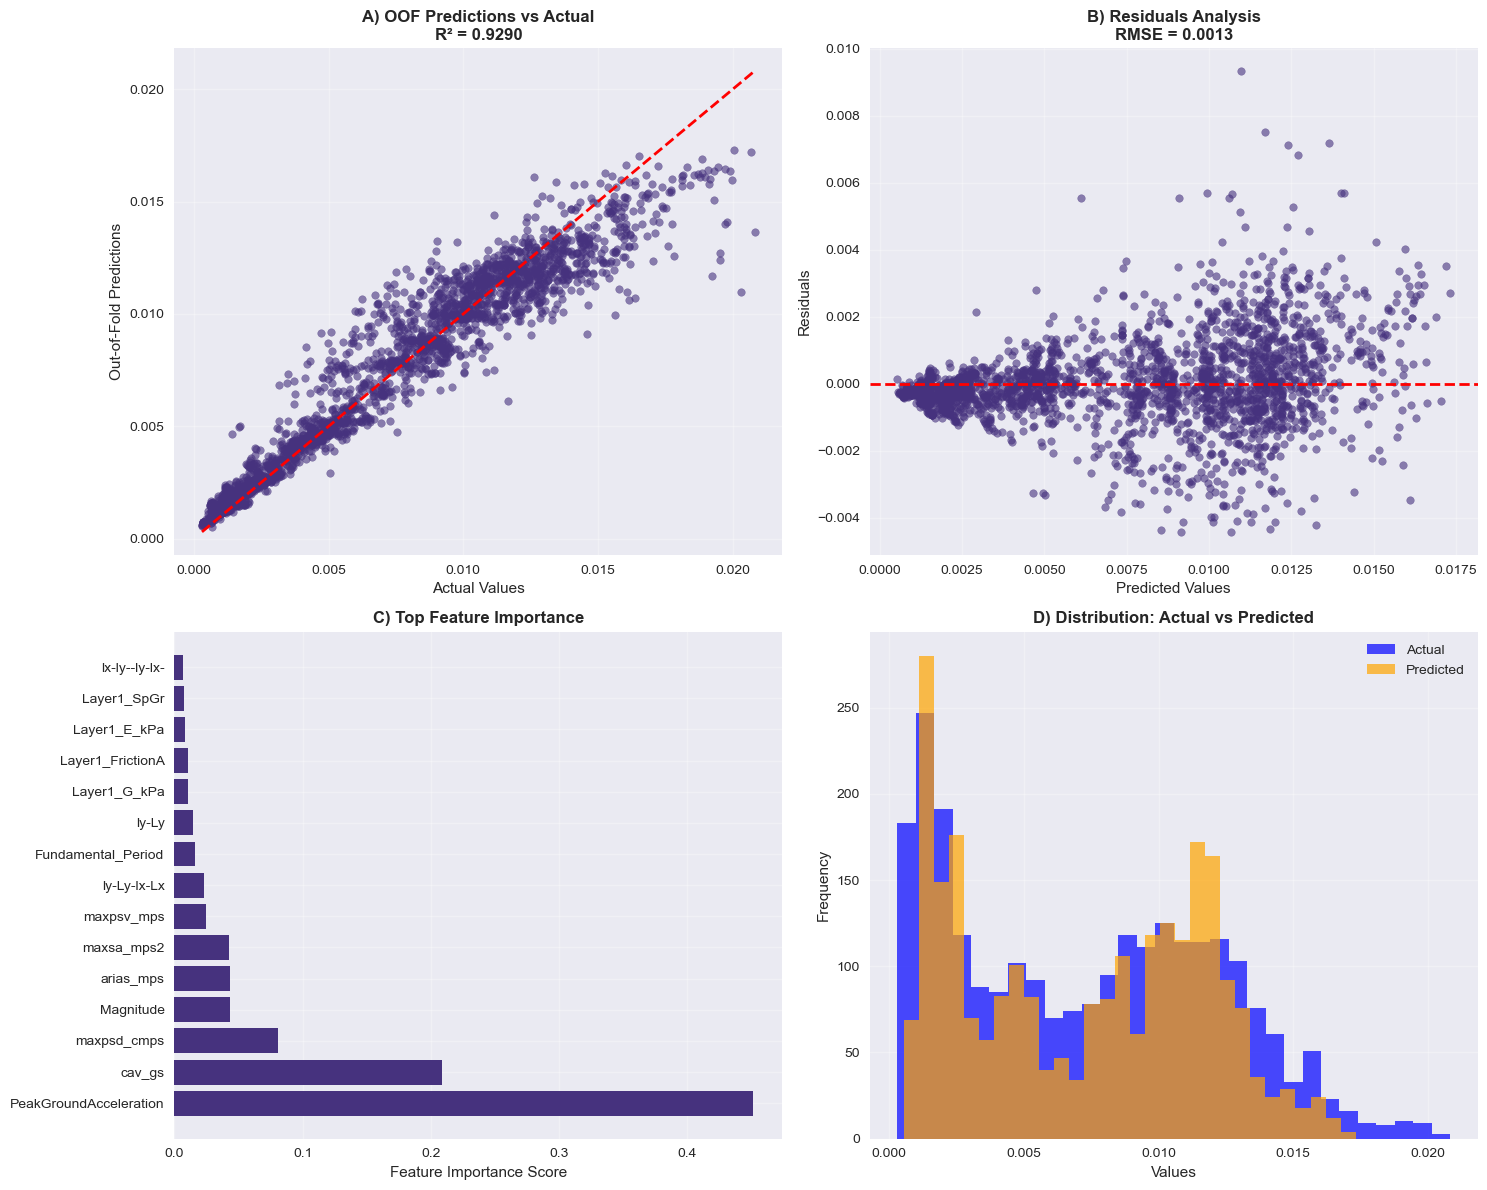


📊 RESEARCH PAPER R²: 0.928964
✅ Complete final model information saved to: ModelInfo_Fixed Model_.txt
📊 Final Model R² Score: 0.938272
📈 Final Model RMSE: 0.001211


In [15]:
# SINGLE LINE EXECUTION
# =====================
# Execute with data export
X_clean = X.apply(pd.to_numeric, errors='coerce')
y_clean = y.values.ravel() if hasattr(y, 'values') else y
parameters = {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.04116115091176691, 
                           'subsample': 0.6850521451721231, 'colsample_bytree': 0.8887781922242812, 
                           'min_child_weight': 7, 'reg_lambda': 8.10083378361349, 
                           'random_state': 42}
model, final_model = run_optimized_model_with_data_export(parameters, X, y)

# Simply call with your final model and data
final_model_info = extract_final_model_info(final_model, X_clean, y_clean, "ModelInfo_Fixed Model_.txt")

# For comparing multiple models
# models = {
#     'XGBoost_Final': final_model,
#     'Other_Model': model
# }
# comparison = compare_multiple_models(models, X_clean, y_clean)


